In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soumyadeeproycsbs","key":"5a096f9b6c41b4f9f63e24e48043485e"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12          13880        304  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset                         22KB  2024-10-06 11:27:38           7289        116  1.0              
yusufdelikkaya/datascience-salaries-2024                     Data Science Salaries 2024                           69KB  2024-10-23 18:39:50           1089         28  0.88235295       
lainguyn123/student-performance-factors                      Student Perfor

In [ ]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 97% 144M/149M [00:01<00:00, 183MB/s]
100% 149M/149M [00:01<00:00, 149MB/s]


In [ ]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split, KFold
import numpy as np

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))  # ['glioma', 'meningioma', 'nontumor', 'pituitary']

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load the training and testing data
X_train, y_train = load_data('/content/Training')
X_test, y_test = load_data('/content/Testing')

# Optional: Split training data into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print data shapes to verify
print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels: {y_test.shape}")


Training data shape: (4569, 224, 224, 3), Labels: (4569,)
Validation data shape: (1143, 224, 224, 3), Labels: (1143,)
Testing data shape: (1311, 224, 224, 3), Labels: (1311,)


In [ ]:
def build_scnn():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    model = Model(input_layer, x)
    return model


In [ ]:
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    model = Model(base_model.input, x)
    return model


In [ ]:
def build_edcnn_with_fc_layers():
    # Build Shallow CNN (SCNN) Model
    scnn = build_scnn()

    # Build VGG16 Model for Deep Features
    vgg16 = build_vgg16()

    # Concatenate outputs of SCNN and VGG16
    combined = Concatenate()([scnn.output, vgg16.output])

    # FC-V3 Layer: 640 Neurons
    fc_v3 = Dense(640, activation='relu', name='fc_v3')(combined)

    # FC-V2 Layer: 1024 Neurons
    fc_v2 = Dense(1024, activation='relu', name='fc_v2')(fc_v3)
    fc_v2 = Dropout(0.5)(fc_v2)  # Add dropout to prevent overfitting

    # FC-V1 Layer: 512 Neurons
    fc_v1 = Dense(512, activation='relu', name='fc_v1')(fc_v2)

    # Output Layer: 3 neurons for 3 tumor classes (glioma, meningioma, pituitary)
    output_layer = Dense(4, activation='softmax', name='output')(fc_v1)

    # Define the model
    model = Model(inputs=[scnn.input, vgg16.input], outputs=output_layer)

    return model


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit([X_train, X_train], y_train,
                    validation_split=0.2,
                    epochs=12,
                    batch_size=32)

Epoch 1/12
115/115 [==============================] - 605s 5s/step - loss: 0.7152 - accuracy: 0.7064 - val_loss: 0.4993 - val_accuracy: 0.8129
Epoch 2/12
115/115 [==============================] - 593s 5s/step - loss: 0.3757 - accuracy: 0.8523 - val_loss: 0.2849 - val_accuracy: 0.8961
Epoch 3/12
115/115 [==============================] - 590s 5s/step - loss: 0.1831 - accuracy: 0.9305 - val_loss: 0.1878 - val_accuracy: 0.9453
Epoch 4/12
115/115 [==============================] - 589s 5s/step - loss: 0.1180 - accuracy: 0.9562 - val_loss: 0.4217 - val_accuracy: 0.8687
Epoch 5/12
115/115 [==============================] - 596s 5s/step - loss: 0.0819 - accuracy: 0.9691 - val_loss: 0.1853 - val_accuracy: 0.9508
Epoch 6/12
115/115 [==============================] - 592s 5s/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.2395 - val_accuracy: 0.9278
Epoch 7/12
115/115 [==============================] - 590s 5s/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.2302 - val_accuracy: 0.9453

In [ ]:
loss, accuracy = model.evaluate([X_test, X_test], y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

41/41 [==============================] - 27s 649ms/step - loss: 0.1860 - accuracy: 0.9672
Test Accuracy: 96.72%


In [ ]:
import numpy as np

# Get predicted probabilities for each class (shape: [num_samples, 4])
y_pred_probs = model.predict([X_test, X_test], verbose=1)

# Convert probabilities to class labels (0, 1, 2, or 3)
y_pred = np.argmax(y_pred_probs, axis=1)

41/41 [==============================] - 27s 652ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict([X_test, X_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Define class names
class_names = ['glioma', 'meningioma', 'pituitary','notumor']

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

41/41 [==============================] - 26s 632ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.94      0.93      0.93       306
   pituitary       0.98      0.99      0.99       405
     notumor       0.96      0.98      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



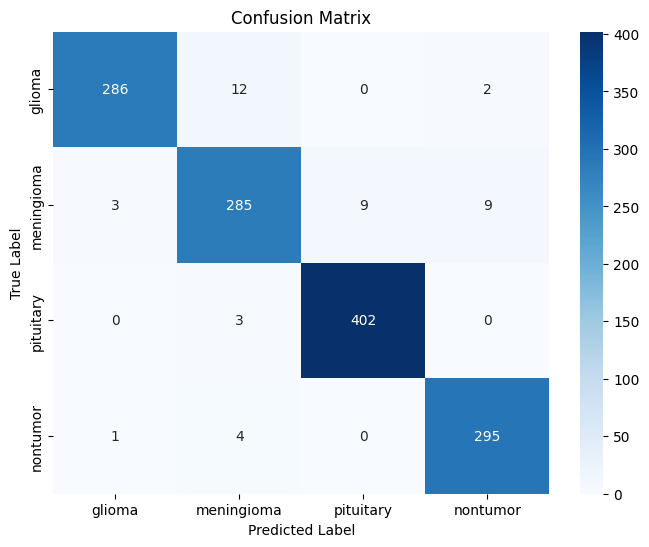

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import io
import numpy as np
import cv2
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# Model Prediction Function
def img_pred(uploader):
    if not uploader.value:
        print("No Image Uploaded/Invalid Image File")
        return

    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))

    # Convert to OpenCV format, resize to (224, 224), and reshape
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage, (224, 224))  # Resize to match model's input layer size
    img = img.reshape(1, 224, 224, 3) / 255.0  # Normalize as model expects

    # Pass two copies of the image to match model input requirements
    prediction = model.predict([img, img])
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map prediction to label
    if predicted_class == 0:
        p = 'Glioma Tumor'
    elif predicted_class == 1:
        p = 'No Tumor'
    elif predicted_class == 2:
        p = 'Meningioma Tumor'
    else:
        p = 'Pituitary Tumor'

    print(f'The Model predicts: {p}')

# Define the uploader and prediction button
uploader = widgets.FileUpload(accept='image/*', multiple=False)
button = widgets.Button(description='Predict')
output = widgets.Output()

# Button click function
def on_button_clicked(_):
    with output:
        clear_output()  # Clear previous output
        try:
            img_pred(uploader)
        except Exception as e:
            print(f'Error: {e}')

button.on_click(on_button_clicked)

# Display uploader, button, and output area
display(widgets.VBox([uploader, button, output]))
